### 10.1 Transfer Learning

![ScreenS/11.1_Transferl.PNG](ScreenS/11.1_Transferl.PNG)

![ScreenS/11.1_Transferl2.PNG](ScreenS/11.1_Transferl2.PNG)


#### 10.2 Veri seti hazirlanmasi ve On işleme


100%|██████████| 345M/345M [00:14<00:00, 24.5MB/s] 
100%|██████████| 502/502 [00:00<00:00, 499kB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 15.0MB/s]


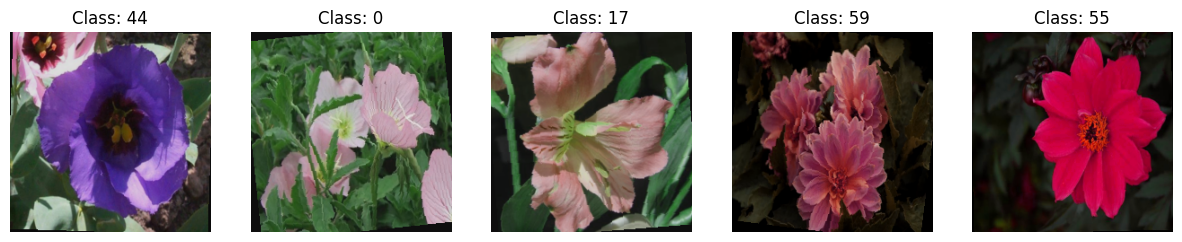

In [10]:
import torch  # PyTorch kütüphanesini içe aktarıyoruz
import torch.nn as nn  # Sinir ağı katmanları için PyTorch modülünü içe aktarıyoruz
import torch.optim as optim  # Optimizasyon algoritmalarını içe aktarıyoruz
import torchvision.transforms as transforms  # Görüntü dönüşümleri için modülü içe aktarıyoruz
import torchvision.datasets as datasets  # Hazır veri setlerini kullanmak için modülü içe aktarıyoruz
import torchvision.models as models  # Önceden eğitilmiş modelleri yüklemek için modülü içe aktarıyoruz
from torch.utils.data import DataLoader  # Veri yükleyici için PyTorch modülünü içe aktarıyoruz
from tqdm import tqdm  # Eğitim sürecini izlemek için ilerleme çubuğunu içe aktarıyoruz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Cihaz seçimi (GPU varsa kullan, yoksa CPU kullan)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Veri seti dönüşümleri (Data Augmentation eklendi)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNet giriş boyutunu 224x224 olarak ayarlıyoruz
    transforms.RandomHorizontalFlip(),  # Görüntüleri yatay çevirerek veri artırımı yapıyoruz
    transforms.RandomRotation(10),  # Görüntüleri rastgele 10 dereceye kadar döndürüyoruz
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Renk varyasyonları ekliyoruz
    transforms.ToTensor(),  # Görüntüleri tensöre çeviriyoruz
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Piksel değerlerini normalize ediyoruz
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Test veri seti için giriş boyutunu ayarlıyoruz
    transforms.ToTensor(),  # Görüntüleri tensöre çeviriyoruz
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Piksel değerlerini normalize ediyoruz
])

# Oxford Flowers 102 veri setini yükleme (Eğitim ve test veri setleri)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context  # SSL doğrulamasını devre dışı bırakıyoruz

train_dataset = datasets.Flowers102(root="./data", split="train", transform=transform_train, download=True)  # Eğitim veri setini indiriyoruz
test_dataset = datasets.Flowers102(root="./data", split="val", transform=transform_test, download=True)  # Test veri setini indiriyoruz

ssl._create_default_https_context = ssl.create_default_context  # SSL doğrulamasını tekrar etkinleştiriyoruz

# Rastgele 5 örnek seçme
indices = torch.randint(len(train_dataset), (5,))
samples = [train_dataset[i] for i in indices]

# Görselleştirme
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (image, label) in enumerate(samples):
    image = image.numpy().transpose((1, 2, 0))  # Tensörü görüntü formatına dönüştürme
    image = (image * 0.5) + 0.5  # Normalizasyonu geri alma
    axes[i].imshow(image)
    axes[i].set_title(f"Class: {label}")
    axes[i].axis("off")
plt.show()

# Veri yükleyicileri oluşturma
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Eğitim veri yükleyicisini oluşturuyoruz
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)  # Test veri yükleyicisini oluşturuyoruz

#### 11.3 Tranfer Learning ve Model Eğitimi 


In [11]:
# MobileNetV2 modelini yükleme (Önceden eğitilmiş ağırlıklarla)
model = models.mobilenet_v2(pretrained=True)  # MobileNetV2 modelini indiriyoruz

# Sınıflandırıcı katmanı değiştirme (Çıkış sayısını 102 sınıfa uyarlıyoruz)
num_ftrs = model.classifier[1].in_features  # Mevcut sınıflandırıcı katmanının giriş özellik sayısını alıyoruz
model.classifier[1] = nn.Linear(num_ftrs, 102)  # Son katmanı Oxford Flowers 102 için değiştiriyoruz
model = model.to(device)  # Modeli belirtilen cihaza (GPU/CPU) taşıyoruz

# Kayıp fonksiyonu ve optimizer tanımlama
criterion = nn.CrossEntropyLoss()  # Çok sınıflı sınıflandırma için çapraz entropi kaybı kullanıyoruz
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)  # Adam optimizasyon algoritmasını kullanıyoruz
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # StepLR ekleme

# Modeli eğitme işlemi
epochs = 3  # Eğitim döngüsünü 25 epoch olarak belirliyoruz
for epoch in tqdm(range(epochs)):  # Her epoch için ilerleme çubuğu gösteriyoruz
    model.train()  # Modeli eğitim moduna alıyoruz
    running_loss = 0.0  # Kümülatif kayıp değerini sıfırlıyoruz
    for images, labels in tqdm(train_loader):  # Eğitim veri yükleyicisini döngüye alıyoruz
        images, labels = images.to(device), labels.to(device)  # Görüntüleri ve etiketleri cihaza taşıyoruz
        optimizer.zero_grad()  # Önceki gradyanları sıfırlıyoruz
        outputs = model(images)  # Model ile tahmin yapıyoruz
        loss = criterion(outputs, labels)  # Kayıp değerini hesaplıyoruz
        loss.backward()  # Geri yayılım (backpropagation) işlemini gerçekleştiriyoruz
        optimizer.step()  # Ağırlıkları güncelliyoruz
        running_loss += loss.item()  # Toplam kayıp değerini güncelliyoruz
    scheduler.step()  # Öğrenme oranı güncelleme
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")  # Epoch sonunda ortalama kaybı yazdırıyoruz
    
# modeli kaydetme
torch.save(model.state_dict(), "mobilenet_flowers102.pth")

c:\Users\mfurk\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mfurk\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\mfurk/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 59.6MB/s]
 33%|███▎      | 1/3 [01:50<03:40, 110.26s/it]

Epoch 1, Loss: 4.5194


 67%|██████▋   | 2/3 [03:29<01:43, 103.87s/it]

Epoch 2, Loss: 2.5207


100%|██████████| 3/3 [05:02<00:00, 100.94s/it]

Epoch 3, Loss: 1.6859


#### 11.4 Modelin Test Edilmesi

100%|██████████| 128/128 [00:42<00:00,  2.99it/s]


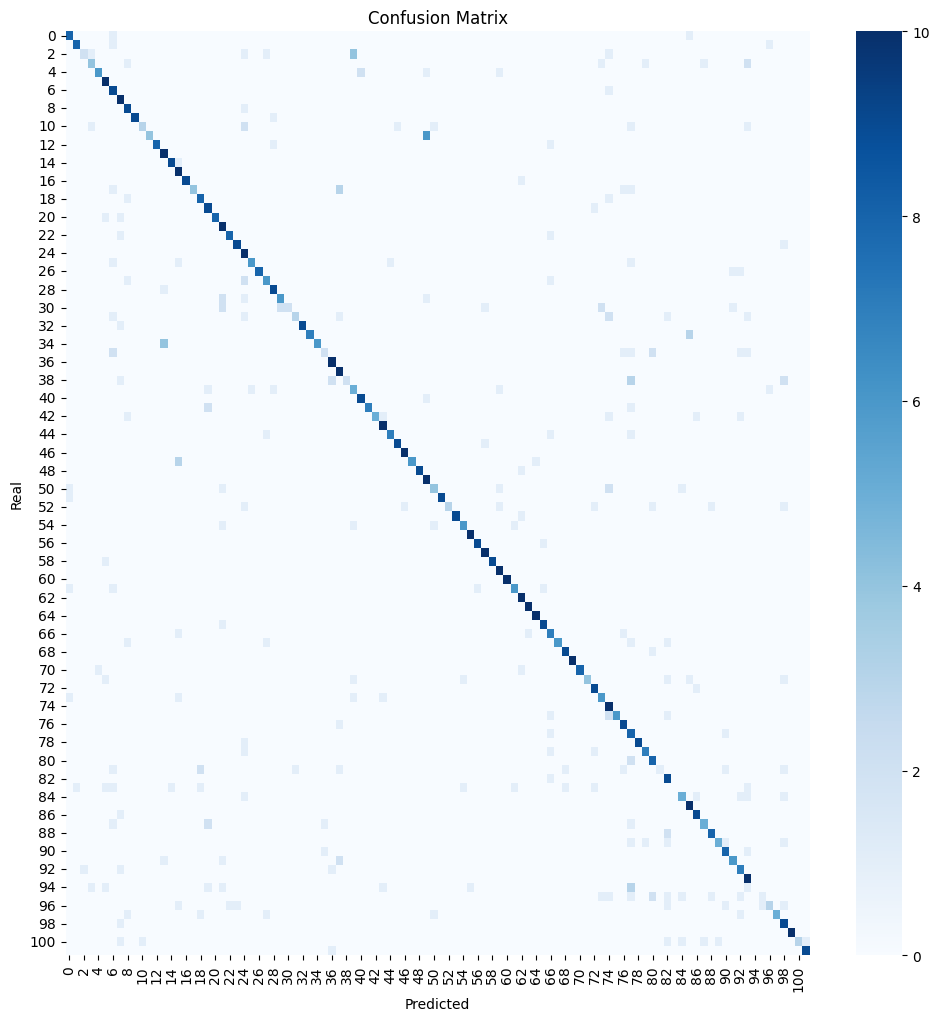

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.89      0.80      0.84        10
           2       0.67      0.20      0.31        10
           3       0.57      0.40      0.47        10
           4       0.86      0.60      0.71        10
           5       0.67      1.00      0.80        10
           6       0.45      0.90      0.60        10
           7       0.56      1.00      0.71        10
           8       0.60      0.90      0.72        10
           9       1.00      0.90      0.95        10
          10       0.75      0.30      0.43        10
          11       1.00      0.40      0.57        10
          12       1.00      0.80      0.89        10
          13       0.62      1.00      0.77        10
          14       0.90      0.90      0.90        10
          15       0.56      1.00      0.71        10
          16       1.00      0.90      0.95        10
          17       1.00    

c:\Users\mfurk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mfurk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mfurk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [12]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
# confusion matrix
cm = confusion_matrix(all_labels, all_preds) 
plt.figure(figsize = (12,12))
sns.heatmap(cm, annot = False, cmap = "Blues")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()   

print(classification_report(all_labels, all_preds))